In [2]:
import sqlite3
import enum

FIG_PATH = "/home/tim/Projects/bachelor-thesis/figs/"
DB_PATH = "/home/tim/idintfw.db"

con = sqlite3.connect(DB_PATH)
c = con.cursor()
rows = c.execute("SELECT * FROM Runs LEFT JOIN Errors ON Runs.ID=Errors.Run")

class App:
    def __init__(self, sources, sinks, classes, methods, statements, cgsize):
        self.sources = sources
        self.sinks = sinks
        self.classes=classes
        self.methods=methods
        self.statements=statements
        self.cgsize=cgsize
        self.runs = []
        
    def addRun(self, run):
        self.runs.append(run)

class Direction(enum.Enum):
    Forwards = 0
    Backwards = 1
    
class Run:
    def __init__(self, direction, maxMem, infoflowEdges, aliasEdges, timeElapsed, dataflowTime, 
                 leaks, terminationState, absCountInfoflow, absCountAlias, runID):
        if direction == "FastSolverfw":
            self.direction = Direction.Forwards
        elif direction == "FastSolverbw":
            self.direction = Direction.Backwards
        else:
            print("ERROR: Unknown direction!")
        self.maxMem = maxMem
        self.infoflowEdges = infoflowEdges
        self.aliasEdges = aliasEdges
        self.timeElapsed = timeElapsed
        self.dataflowTime = dataflowTime
        self.leaks = leaks
        self.absCountInfoflow = absCountInfoflow
        self.absCountAlias = absCountAlias
        self.memoryTimeout = terminationState == 2 
        self.timeTimeout = terminationState == 1
        self.runID = runID
        
apps = {}
for row in rows:
    name = row[1]
    
    if not name in apps:
        apps[name] = App(row[16], row[17], row[18], row[19], row[20], row[21])

    # no need to add uncompleted runs
    if row[6] == None or row[6] == -1:
        continue
    # only verify source sink manager when analysis started
    app = apps[name]
    if row[16] != app.sources:
        print("Sources differ for %s: %s to %s" % (name, app.sources, row[16]))
        continue
    if row[17] != app.sinks:
        print("Sinks differ for %s: %s to %s" % (name, app.sinks, row[17]))
        continue

    if row[25] == 1:
        app.addRun(Run(row[2], row[7], row[22], row[23], row[5], row[6], row[14], row[15], row[12], row[13], row[25]))
    

def runToColor(run):
    if run.memoryTimeout:
        return "#d62728"
    elif run.timeTimeout:
        return "#ff7f0e"
    else:
        return "#1f77b4"
    
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from pylatex.utils import escape_latex 

matplotlib.rcParams.update({
    "pgf.texsystem": "lualatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


Sources differ for com.cabs.apk: None to 12
Sources differ for com.dywx.larkplayer.apk: 15 to 16
Sources differ for HinKhoj.Dictionary.apk: None to 12
Sources differ for com.astepanov.mobile.mathforkids.apk: None to 9
Sources differ for com.astepanov.mobile.mathforkids.apk: None to 9
Sources differ for com.cabs.apk: None to 12
Sources differ for com.dywx.larkplayer.apk: 15 to 16
Sources differ for taxi.android.client.apk: None to 26
Sources differ for com.cabs.apk: None to 12
Sources differ for com.astepanov.mobile.mathforkids.apk: None to 9
Sources differ for com.cisco.wx2.android.apk: None to 11
Sources differ for taxi.android.client.apk: None to 26


kr.co.smartstudy.cartown_android_googlemarket.apk
ru.beeline.services.apk
com.radio.fmradio.apk
com.backgrounderaser.cutout.photoeditor.apk
com.microsoft.office.officehubrow.apk
com.autoscout24.apk
com.bplus.vtpay.apk
hr.palamida.apk
com.kinky.fetlifestyle.apk
com.indianexpress.android.apk
com.euronews.express.apk
com.apartmentlist.mobile.apk
nineNewsAlerts.nine.com.apk
com.grabtaxi.passenger.apk
com.hk01.news_app.apk
mnn.Android.apk
com.simplepractice.video.apk
com.google.android.apps.seekh.apk
com.skyhealth.glucosebuddyfree.apk
com.rcmbusiness.apk
com.streema.simpleradio.apk
com.orange.kidspiano.music.songs.apk
com.lezhin.comics.apk
com.videocall.randomfriendvideo.apk
dbx.taiwantaxi.apk
com.socialnetwork.hookupsapp.apk
com.clusterdev.hindikeyboard.apk
document.scanner.scan.pdf.image.text.apk
com.splendapps.voicerec.apk
app.habitaclia2.apk
kr.co.smartstudy.dinoworld_android_googlemarket.apk
com.opera.touch.apk
de.etecture.ekz.onleihe.apk
com.kevinbradford.games.pklg2.apk
ua.insomnia.k

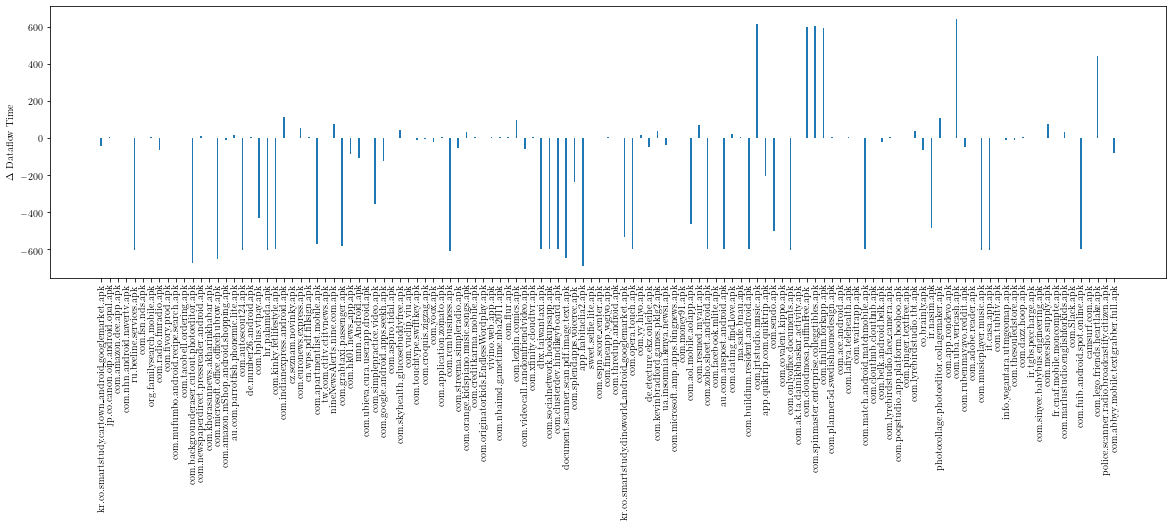

In [3]:
# Delta of each app

xfw = []
datafw = []
cfw = []
xbw = []
databw = []
cbw = []

delta = []
for name, app in apps.items():
    if len(app.runs) != 2:
        continue
        
    leaks = -1
    d = 0
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xfw.append(escape_latex(name))
            cfw.append(runToColor(run))
            d -= run.dataflowTime
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            xbw.append(escape_latex(name))
            cbw.append(runToColor(run))
            d += run.dataflowTime
#         if leaks == -1:
#             leaks = run.leaks
#         elif leaks != run.leaks:
#             print(f"Leaks differ for {name}: {leaks} vs {run.leaks}")
    delta.append(d)
        
print(sum(delta)/len(xfw))
print(len(xfw))
            
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111)
ind = np.arange(len(xfw))
width = 0.2
ax.bar(ind, delta, width)
# ax.bar(ind - width/2, datafw, width, color=cfw)
# ax.bar(ind + width/2, databw, width, color=cbw)
ax.set_xticklabels(xfw)
plt.xticks(ind)
ax.set_ylabel("$\\Delta$ Dataflow Time")
_ = plt.xticks(rotation=90)
plt.savefig(FIG_PATH + "dataflowDelta.pgf")

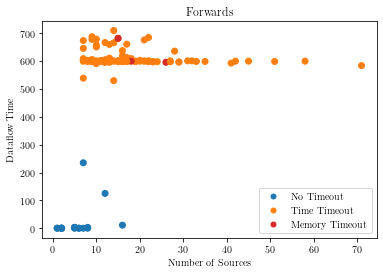

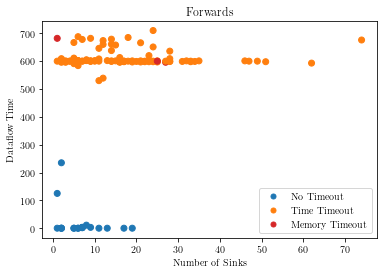

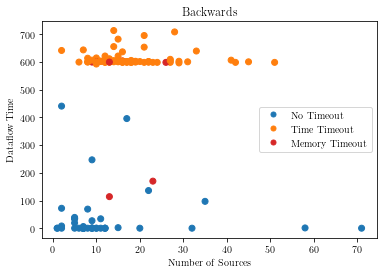

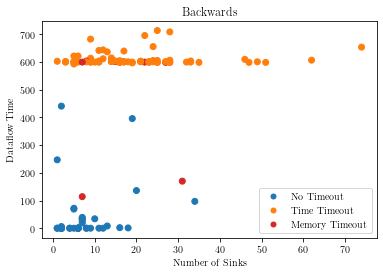

In [4]:
# Per Sources/Sinks
blue_dot = mlines.Line2D([], [], color='#1f77b4', marker='.', linestyle='None',
                          markersize=10, label='No Timeout')
orange_dot = mlines.Line2D([], [], color='#ff7f0e', marker='.', linestyle='None',
                          markersize=10, label='Time Timeout')
red_dot = mlines.Line2D([], [], color='#d62728', marker='.', linestyle='None',
                          markersize=10, label='Memory Timeout')
handles = [blue_dot, orange_dot, red_dot]

xfw1 = []
xfw2 = []
datafw = []
cfw = []
xbw1 = []
xbw2 = []
databw = []
cbw = []
for name, app in apps.items():
    if len(app.runs) != 2:
        continue
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            xfw1.append(app.sources)
            xfw2.append(app.sinks)
            c = runToColor(run)
            if c == "#ff7f0e" and run.dataflowTime < 400:
                print(name)
            cfw.append(runToColor(run))
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            xbw1.append(app.sources)
            xbw2.append(app.sinks)
            cbw.append(runToColor(run))

plt.figure()
plt.scatter(xfw1, datafw, c=cfw)
plt.xlabel("Number of Sources")
plt.ylabel("Dataflow Time")
plt.title("Forwards")
plt.legend(handles=handles)
plt.savefig(FIG_PATH + "fw_dataflow-sources.pgf")       
plt.figure()
plt.scatter(xfw2, datafw, c=cfw)
plt.xlabel("Number of Sinks")
plt.ylabel("Dataflow Time")
plt.title("Forwards")
plt.legend(handles=handles)
plt.savefig(FIG_PATH + "fw_dataflow-sinks.pgf")

plt.figure()
plt.scatter(xbw1, databw, c=cbw)
plt.xlabel("Number of Sources")
plt.ylabel("Dataflow Time")
plt.title("Backwards")
plt.legend(handles=handles)
plt.savefig(FIG_PATH + "bw_dataflow-sources.pgf")
plt.figure()
plt.scatter(xbw2, databw, c=cbw)
plt.xlabel("Number of Sinks")
plt.ylabel("Dataflow Time")
plt.title("Backwards")
plt.legend(handles=handles)
plt.savefig(FIG_PATH + "bw_dataflow-sinks.pgf")

In [5]:
datafw = []
datafw2 = []
memfw = []
memfw2 = []
iabsfw = []
iabsfw2 = []
aabsfw = []
aabsfw2 = []
tofw = [0, 0, 0]

databw = []
databw2 = []
membw = []
membw2 = []
iabsbw = []
iabsbw2 = []
aabsbw = []
aabsbw2 = []
tobw = [0, 0, 0]

for name, app in apps.items():
    if len(app.runs) != 2:
        continue
    
    for run in app.runs:
        if run.direction == Direction.Forwards:
            datafw.append(run.dataflowTime)
            memfw.append(run.maxMem)
            iabsfw.append(run.absCountInfoflow)
            aabsfw.append(run.absCountAlias)
            if run.memoryTimeout:
                tofw[2] += 1
            elif run.timeTimeout:
                tofw[1] += 1
            else:
                tofw[0] += 1
                datafw2.append(run.dataflowTime)
                memfw2.append(run.maxMem)
                iabsfw2.append(run.absCountInfoflow)
                aabsfw2.append(run.absCountAlias)
        elif run.direction == Direction.Backwards:
            databw.append(run.dataflowTime)
            membw.append(run.maxMem)
            iabsbw.append(run.absCountInfoflow)
            aabsbw.append(run.absCountAlias)
            if run.memoryTimeout:
                tobw[2] += 1
            elif run.timeTimeout:
                tobw[1] += 1
            else:
                tobw[0] += 1
                databw2.append(run.dataflowTime)
                membw2.append(run.maxMem)
                iabsbw2.append(run.absCountInfoflow)
                aabsbw2.append(run.absCountAlias)
                
print(f"Average Runtime & ${sum(datafw) / sum(tofw)}s$ & ${sum(databw) / sum(tobw)}s$\\\\")
print(f"Median Runtime & ${np.median(datafw)}s$ & ${np.median(databw)}s$\\\\") 
print("\\hline")
print(f"Abstractions Infoflow & ${round(sum(iabsfw)/sum(tofw))}$ & ${round(sum(iabsbw)/sum(tobw))}$\\\\")
print(f"Abstractions Alias & ${round(sum(aabsfw)/sum(tofw))}$ & ${round(sum(aabsbw)/sum(tobw))}$\\\\")
print(f"Total Abstractions & ${round(sum(iabsfw)/sum(tofw))+round(sum(aabsfw)/sum(tofw))}$ & ${round(sum(iabsbw)/sum(tobw))+round(sum(aabsbw)/sum(tobw))}$\\\\")
print("\\hline")
print(f"Average Max Memory Consumption & ${round(sum(memfw) / sum(tofw), 2)} GB$ & ${round(sum(membw) / sum(tobw), 2)} GB$\\\\")
print("\\hline")
print(f"Memory Timeouts & ${round((tofw[2] / sum(tofw) * 100), 2)}\\%$ & ${round((tobw[2] / sum(tobw) * 100), 2)}\\%$\\\\")
print(f"Time Timeouts & ${round((tofw[1] / sum(tofw) * 100), 2)}\\%$ & ${round((tobw[1] / sum(tobw) * 100), 2)}\\%$\\\\")
print()
print(f"Average Runtime & ${sum(datafw2) / tofw[0]}s$ & ${round(sum(databw2) / tobw[0],2)}s$\\\\")
print(f"Median Runtime & ${np.median(datafw2)}s$ & ${np.median(databw2)}s$\\\\")
print("\\hline")
print(f"Abstractions Infoflow & ${round(sum(iabsfw2)/sum(tofw))}$ & ${round(sum(iabsbw2)/sum(tobw))}$\\\\")
print(f"Abstractions Alias & ${round(sum(aabsfw2)/sum(tofw))}$ & ${round(sum(aabsbw2)/sum(tobw))}$\\\\")
print(f"Total Abstractions & ${round(sum(iabsfw2)/sum(tofw))+round(sum(aabsfw2)/sum(tofw))}$ & ${round(sum(iabsbw2)/sum(tobw))+round(sum(aabsbw2)/sum(tobw))}$\\\\")
print("\\hline")
print(f"Average Max Memory Consumption & ${round(sum(memfw2) / tofw[0], 2)} GB$ & ${round(sum(membw2) / tobw[0], 2)} GB$\\\\")

Average Runtime & $514.8455284552846s$ & $403.2113821138211s$\\
Median Runtime & $600.0s$ & $600.0s$\\
\hline
Abstractions Infoflow & $33693688$ & $12505574$\\
Abstractions Alias & $12219051$ & $30442360$\\
Total Abstractions & $45912739$ & $42947934$\\
\hline
Average Max Memory Consumption & $24703.24 GB$ & $25560.15 GB$\\
\hline
Memory Timeouts & $2.44\%$ & $6.5\%$\\
Time Timeouts & $81.3\%$ & $58.54\%$\\

Average Runtime & $19.2s$ & $38.7s$\\
Median Runtime & $0.0s$ & $0.0s$\\
\hline
Abstractions Infoflow & $380172$ & $625702$\\
Abstractions Alias & $133316$ & $1366758$\\
Total Abstractions & $513488$ & $1992460$\\
\hline
Average Max Memory Consumption & $6915.35 GB$ & $15835.63 GB$\\
